![image info](./thumb0.png)

## Part I - Build a Slater determinant basis and compute energies and NACs

In this tutorial, we will learn how to use Libra to apply various post-processing tools on the vibronic Hamiltonian files we generated in the tutorial of step2 of the neglect-of-back-reaction approximation (NBRA) workflow.

For those wishing to start from this step, please unpack the tarball provided in the step3 folder. The name of the tarball is "rutile_TiO2_step2_data". If not done already, please unpack the tarball. From the command line, this can be done as:

tar -xzf rutile_TiO2_step2_data

This tutorial will show users how to construct a Slater determinant basis, either manually or using Libra to auto-generate them. Then, we will compute the energies and nonadiabatic couplings in the Slater determinant basis. 

## Table of contents
<a name="toc"></a>

1. [Importing Libra and other dependencies](#Import)
2. [Define a function to retrieve required data](#Define_getter)  
3. [Define a function to print the Slater determinant basis](#Define_getter)  
4. [Define a function to sort Slater determinant energies](#Define_sorter) 
5. [Define a function to output the sorted vibronic Hamiltonian](#Define_output_sorted_hvib) 
6. [Applying step3](#apply_step3)  
    6.1. [Retrieve step2 data](#get_step2_data)  
    6.2. [Build the Slater determinant basis](#build_sd_basis)    
     &nbsp; 6.2.1 [Manually_construct a Slater determinant basis](#manually_generate)  
     &nbsp; 6.2.2 [Using Libra to auto-generate a Slater determinant basis](#auto_generate)     
    6.3. [Form spin-adapated configuration basis](#build_sac)  
    6.4. [Perform the basis transformation](#basis_transform)  
7. [Plotting the Step3 data](#plot_step3_data)

### A. Learning objectives
* To manually construct a Slater determinant basis 
* To use Libra to auto-generate a Slater determinant basis
* To compute the energies and nonadiabatic couplings in the Slater determinant basis

### B. Use cases
* [Manually construct a Slater determinant basis](#manually_generate)
* [Using Libra to auto-generate a Slater determinant basis](#auto_generate)
* [Compute the energies and nonadiabatic couplings in the SD basis](#run_step3)
* [Using matplotlib to visualize the properties of the vibronic Hamiltonian in the Slater determinant basis](#plot_step3)

### C. Functions

- `libra_py`
  - `workflows`
    -  `nbra`
      - `step3`
        - [`build_SD_basis`](#sd_basis_build)
        - [`run`](#run_step3)
        
  - `data_read`
    - [`get_data_sets`](#data_read)

  - `data_stat`
    - [`cmat_stat2`](#data_stat)

Before we begin the tutorial, let us unpack the tarball by running the following cell

In [16]:
!tar -xf rutile_TiO2_step2_data

## 1. Importing Libra and other dependencies <a name="Import"></a>
[Return to Table of contents](#toc)

In the cell below, we import Libra and other dependencies such as numpy and matplotlib

In [1]:
from liblibra_core import *
from libra_py import *
import os
import sys
import time
from libra_py.workflows.nbra import step3

import numpy as np
import matplotlib.pyplot as plt

colors = {}
colors.update({"1": '#000000'})  # Black 
colors.update({"2": '#000099'})  # Blue  
colors.update({"3": '#006400'})  # Green 
colors.update({"4": '#990000'})  # Red   
colors.update({"5": '#8B008B'})  # Purple
colors.update({"6": '#FF8C00'})  # Orange
colors.update({"9": '#4d4d4d'})  # Gray  
color_index = ["1","2","3","4","5","6","9"]


/u/fzheng/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/u/fzheng/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/u/fzheng/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::allocator<fl

## 2. Define a function to retrieve required data <a name="Define_getter"></a>
[Return to Table of contents](#toc)

In the cell below, we define a function that will read in the vibronic Hamiltonian, overlap matricies, and time-derivative overlap matrices from the step2 calculations. These data are in the Kohn-Sham orbtial basis.

<a name="data_read"></a>

In [2]:
def get_step2_data(_params):
    """
    A light function to obtain the step2 data
    """

    params = dict(_params)

    # Fetching the overlap matricies
    params.update({ "data_re_prefix" : "S_dia_ks_", "data_re_suffix" : "_re",
                    "data_im_prefix" : "S_dia_ks_", "data_im_suffix" : "_im"  } )
    S = data_read.get_data_sets(params)
    #print ("\n")
    #S[0][0].show_matrix()
    #print (S[0][0].get(0,0))
    #sys.exit(0)

    # Fetching the time-derivative overlap matricies
    params.update({ "data_re_prefix" : "St_dia_ks_", "data_re_suffix" : "_re",
                    "data_im_prefix" : "St_dia_ks_", "data_im_suffix" : "_im"  } ) 
    St = data_read.get_data_sets(params)
    #print ("\n")
    #St[0][0].show_matrix()
    #sys.exit(0)
 
    # Fetching the vibronic Hamiltonian matricies
    params.update({ "data_re_prefix" : "hvib_dia_", "data_re_suffix" : "_re",
                    "data_im_prefix" : "hvib_dia_", "data_im_suffix" : "_im"  } ) 
    Hvib_ks = data_read.get_data_sets(params)
    #print ("\n")
    #Hvib_ks[0][0].show_matrix()
    #sys.exit(0)

    return S, St, Hvib_ks


## 3. Define a function to print the Slater determinant basis <a name="Define_printer"></a>
[Return to Table of contents](#toc)

In the cell below, we define a function that prints the constructed Slater determinant Basis to the screen. 

In [3]:
def print_SD_basis(SD_basis):
    """
    Just a light function to print the SD basis
    """

    for i in range(len(SD_basis)):
        if i == 0:
            print (" GS: ", SD_basis[i])
        else:
            print (" ES "+str(i)+": ", SD_basis[i]) 
    print ("WARNING: The Slater determinant bases above may not be sorted based on their energies\n")


## 4. Define a function to sort Slater determinant energies<a name="Define_sorter"></a>
[Return to Table of contents](#toc)

Once we have formed the Slater determinants, we need to sort them based on their energies. This needs to be done for each step since fluctuations in the underlying Kohn-Sham orbital energies may cause a change in the order of the Slater determinant energies

In [4]:
def sort_SD_energies(Hvib):
    """
    This function goes into the Hvib (SD basis) files and sorts the energies
    For each Hvib file, we are going to obtain a list of lists of orbital index and energy pair
    These orbital index and energy pairs for each step will be sorted based on energies  
    """

    ntraj  = len(Hvib)
    nsnaps = len(Hvib[0])   
    nSD = Hvib[0][0].num_of_cols

    orbital_index_energy_pairs = []

    for traj in range(ntraj):

        orbital_index_energy_pairs.append( [] )

        for snap in range(nsnaps):

            index_energy_pairs = []

            for sd_index in range(nSD):
                index_energy_pairs.append( [ sd_index, Hvib[ traj ][ snap ].get( sd_index, sd_index ).real ]  )

            sorted_index_energy_pairs = merge_sort( index_energy_pairs  ) 
            orbital_index_energy_pairs[traj].append( sorted_index_energy_pairs )

    return orbital_index_energy_pairs


## 5. Define a function to output the sorted vibronic Hamiltonian<a name="Define_output_sorted_hvib"></a>
[Return to Table of contents](#toc)

Once we have sorted the Slater determinant basis based on energies at each step, we need to output the data to text files to be read during the NAMD calculations. Below, we define such a function

In [5]:
def output_sorted_Hvibs(Hvib, orbital_index_energy_pairs):
    """
    This function outputs the vibronic Hamiltonians in the SD basis according to their sorted order
    """

    ntraj  = len(orbital_index_energy_pairs)
    nsnaps = len(orbital_index_energy_pairs[0])
    nSD    = len(orbital_index_energy_pairs[0][0])

    Hvibs_sorted   = []

    for traj in range( ntraj ):

        rd_sorted = "res_sorted_traj"+str(traj)+""
        os.system("rm -r "+rd_sorted)
        os.system("mkdir "+rd_sorted)

        Hvibs_sorted.append( [] )

        for snap in range( nsnaps ):
            Hvib_sorted  = CMATRIX( nSD, nSD)
            for i in range( nSD ):
                for j in range( nSD ):
                    a = orbital_index_energy_pairs[ traj ][ snap ][ i ][ 0 ]
                    b = orbital_index_energy_pairs[ traj ][ snap ][ j ][ 0 ]
                    Hvib_sorted.set( i, j, Hvib[ traj ][ snap ].get( a, b ) )

            Hvibs_sorted[ traj ].append( Hvib_sorted )
            Hvibs_sorted[ traj ][ snap ].real().show_matrix("%s/Hvib_sorted_%i_re" % (rd_sorted, snap))
            Hvibs_sorted[ traj ][ snap ].imag().show_matrix("%s/Hvib_sorted_%i_im" % (rd_sorted, snap))

    return Hvibs_sorted


## 6. Applying Step3<a name="apply_step3"></a>
[Return to Table of contents](#toc)

Now, we are ready to apply step3 in its various forms and fashions. To begin, we will be showing how to retrieve the data from step2. Please recall, that the data from step2 is the following dynamical data:

In the following descriptions, the option of "dia" or "adi" refers to whether of not spin-orbit coupling was used in the step2 calculations. Specifically, "dia" refers to the case without spin-orbit coupling, whereas "adi" refers to the case with spin-orbit coupling. The option of "re" refers to the real part of the data, whereas the option of "im" refers to the imaginary part of the data.  

* `S_(dia/adi)_ks_"N"_(re/im)` - Overlap matrix for time-step "N" in the Kohn-Sham orbital basis 

* `St_(dia/adi)_ks_"N"_(re/im)` - Time-derivative Overlap matrix for time-step "N" and "N+1" in the Kohn-Sham orbital basis

* `hvib_(dia/adi)_"N"_(re/im)` - Vibronic Hamiltonian matrix for the time-step "N" and "N+1" in the Kohn-Sham orbital basis

### 6.1. Retrieve Step2 data<a name="get_step2_data"></a>
[Return to Table of contents](#toc)

In the cell below, we retrieve the step2 data. Specfically, we use the function "get_step2_data(..)" that we defined above. This function returns to us the overlap, time-derivative overlap, and vibornic Hamiltonian matricies in the Kohn-Sham orbital basis, S, St, and Hvib_ks, respectively. The following keyword descriptions may be helpful:

* `num_alpha_ks_orbs` - This is the number of alpha Kohn-Sham orbitals that are included in the step2 data. A requirement is that this is to be equal to the number of beta Kohn-Sham orbitals. The entire index scheme resides on this structure

* `data_dim` - By extension, the dimension of the data (number of rows / columns of the data) is equal to the number of alpha Kohn-Sham orbitals + the number of beta Kohn-Sham orbitals. Due to how the data is output in step2, there will always be an equal number of alpha Kohn-Sham orbitals and beta Kohn-Sham orbitals. Therefore, just leave `data_dim = 2*num_alpha_ks_orbs`

* `act_sp` - How many rows and columns from the data do we even consdier. It is best to consdier as many Kohn-Sham orbitals as possible. For now, keep this to be the size of the enitre data (data_dim). Its value will impact how we build the Slater Determinants

* `start_time` - From which time-step index should we begin reading the step2 data?

* `finish_time` - At which time-step index should we stop reading the step2 data?

In [6]:
# Remove the previous results and temporary working directory from the previous runs. Create a new directory
os.system("rm -r traj0"); os.system("mkdir traj0")
# Create a path to the results directory from step2
res_dir = "/u/fzheng/0.qe_calculations/4.ZnTHPP/1.dimer/6.step2_scfs_258_279/res/"
# Set variables based on your data in step2. Indexing is from 1
num_alpha_ks_orbs = 22 # Number of alpha spin-orbtials in the alpha spin-block from the step2 data. By extension, this is also the number of beta spin-orbitals
data_dim          = 2*num_alpha_ks_orbs # Total number of rows or columns in the step2 data. Keep this value 2*num_alpha_ks_orbs
act_sp            = range(data_dim)     # Consider every spin-orbital to be in our active space
start_time  = 50    # Start reading step2 data at this index   
finish_time = 549   # Stop  reading step2 data at this index   
# Make a parameters dictionary with the relevant information about the step2 data, and then fetch this data
params = { "data_set_paths" : [res_dir],
           "data_dim":data_dim, "active_space":act_sp,
           "isnap":start_time,  "fsnap":finish_time,
         }
# These files contain N x N matrices, which are composed of N/2 x N/2 blocks of alpha and beta orbitals
S, St, Hvib_ks = get_step2_data(params)


### 6.2. Build the Slater Determinant basis<a name="build_sd_basis"></a>
[Return to Table of contents](#toc)

We have fetched the data from step2. Now, let's build the Slater Determinant basis. 

We can either do this manually or have Libra do it. Please be aware that when building the Slater Determinant basis, the orbital indexing is from 1. Below is a schematic of how the Slater Determinant indexing scheme works. Some may find it helpful when manually constructing a Slater Determinant basis.

![image info](./thumb1.png)

#### 6.2.1. Manually construct a Slater determinant basis<a name="manually_generate"></a>
[Return to Table of contents](#toc)

While it is convenient to have Libra auto-generate a Slater determinant basis, it may be the case that the user would like to manually construct such a basis. Recalling that the indexing is from 1 and that the index of the conduction band maximum in the alpha spin channel for our system is index 5, and that the index of the conduction band maximum in the beta spin channel for our system is index 16, one can construct a Slater determinant basis in the following way (shown in the cell below). In this example, we manually construct 3 Slater determinants. The first one is the ground state determinant. The next two are the excitations of an alpha electron from the conduction band maximum to the valence band minimum in the alpha spin channel

bands: 125 - 145
HOMO: 134 (10)
LOMO: 135 (11)

In [23]:
SD_basis_unsorted = [ [10, -31], [11, -31], [12, -31] ]
print_SD_basis(SD_basis_unsorted)
print("Number of Slater Determinant Basis States is:", len(SD_basis_unsorted))
params.update( { "SD_basis":SD_basis_unsorted } )

 GS:  [10, -31]
 ES 1:  [11, -31]
 ES 2:  [12, -31]

Number of Slater Determinant Basis States is: 3


One could easily include more Kohn-Sham orbitals in each of the Slater determinants. As shown in the next cell. Here, we now include both CBM-1 and CBM

In [24]:
SD_basis_unsorted = [ [9, 10, -30, -31], [9, 11,-30, -31], [9, 12, -30, -31] ]
print_SD_basis(SD_basis_unsorted)
print("Number of Slater Determinant Basis States is:", len(SD_basis_unsorted))
params.update( { "SD_basis":SD_basis_unsorted } )

 GS:  [9, 10, -30, -31]
 ES 1:  [9, 11, -30, -31]
 ES 2:  [9, 12, -30, -31]

Number of Slater Determinant Basis States is: 3


#### 6.2.2. Using Libra to auto-generate a Slater determinant basis<a name="auto_generate"></a>
[Return to Table of contents](#toc)

Overall, outside of a few limited examples, the manual construction of the Slater determinants can become a cumbersome process. Luckily, Libra features an option to auto-generate a Slater determinant basis. In doing so, the following parameters must be specified.

* `excitation_type` - Variable for considering either only alpha excitations (1), only beta excitations (2), or both (3)

* `cbm_alpha_index` - This is a very important parameter that is used when having Libra construct the Slater determinant basis. This value corresponds to the index of the conduction band maximum in the alpha spin channel. The indexing beings from 1. 

* `cbm_beta_index` - Analagous to `cbm_alpha_index` but for the beta spin channel

* `alpha_include` - Sets the number of alpha Kohn-Sham orbtials to include in addition to the band edge states

* `beta_include` -  Analagous to `alpha_include` but for the beta spin channel

<a name="sd_basis_build"></a>

In [7]:
# Use Libra to automatically generate the orbitals from Example 1.    
excitation_type = 0 # Select 0 for only alpha-excitations
                    # Select 1 for only beta-excitations
                    # Select 2 for both alpha and beta-excitations
cbm_alpha_index   = 11  # Which of the spin-orbtials is the CBM for the alpha-spin channel? 
cbm_beta_index    = 33 # Which of the spin-orbtials is the CBM for the beta-spin  channel?
alpha_include     = 3  # how many orbitals to include from the cbm alpha index (how many from band edges)
beta_include      = 3  # how many orbitals to include from the cbm beta  index (how many from band edges)
print ("\nGenerating a SD basis for dynamics ...")
print (" You are using "+str(data_dim)+" KS orbitals with an alpha CBM index of "+str(cbm_alpha_index)+" and beta CBM index of "+str(cbm_beta_index)+". Indexing is from 1")
print (" Including", alpha_include, " alpha ks orbitals from the band edges")
print (" Including", beta_include,  " beta  ks orbitals from the band edges")
print (" Chosen Excitation type: ", excitation_type)
print ("  0: only alpha excitations")
print ("  1: only beta  excitations")
print ("  2: both alpha and beta excitations")
print ("Here is your SD basis generated by Libra:")
SD_basis_unsorted = step3.build_SD_basis(data_dim, cbm_alpha_index, alpha_include, cbm_beta_index, beta_include, excitation_type)
print_SD_basis(SD_basis_unsorted)
print("Number of Slater Determinant Basis States is:", len(SD_basis_unsorted))
params.update( { "SD_basis":SD_basis_unsorted } )
#sys.exit(0)


Generating a SD basis for dynamics ...
 You are using 44 KS orbitals with an alpha CBM index of 11 and beta CBM index of 33. Indexing is from 1
 Including 3  alpha ks orbitals from the band edges
 Including 3  beta  ks orbitals from the band edges
 Chosen Excitation type:  0
  0: only alpha excitations
  1: only beta  excitations
  2: both alpha and beta excitations
Here is your SD basis generated by Libra:
 GS:  [8, 9, 10, 11, -30, -31, -32, -33]
 ES 1:  [12, 9, 10, 11, -30, -31, -32, -33]
 ES 2:  [13, 9, 10, 11, -30, -31, -32, -33]
 ES 3:  [14, 9, 10, 11, -30, -31, -32, -33]
 ES 4:  [15, 9, 10, 11, -30, -31, -32, -33]
 ES 5:  [8, 12, 10, 11, -30, -31, -32, -33]
 ES 6:  [8, 13, 10, 11, -30, -31, -32, -33]
 ES 7:  [8, 14, 10, 11, -30, -31, -32, -33]
 ES 8:  [8, 15, 10, 11, -30, -31, -32, -33]
 ES 9:  [8, 9, 12, 11, -30, -31, -32, -33]
 ES 10:  [8, 9, 13, 11, -30, -31, -32, -33]
 ES 11:  [8, 9, 14, 11, -30, -31, -32, -33]
 ES 12:  [8, 9, 15, 11, -30, -31, -32, -33]
 ES 13:  [8, 9, 10, 

### 6.3. Form spin-adapated configuration basis<a name="build_sac"></a>
[Return to Table of contents](#toc)

Libra has the added functionality of being able to form Spin-Adapated Configuration States from the basis of Slater Determinants. For now, we will just leave this matrix to be identity. By doing so, we opt to not spin-adapt our Slater Determinant basis. 

In [8]:
# Define the coefficients for a CI-like basis - just have the diagonals all 1 for now
CI_basis = []
SD_energy_corr = [0.0]*len(params["SD_basis"])
for i in range(len(params["SD_basis"])):
    CI_basis.append( [] )
    for j in range(len(params["SD_basis"])):
        if i == j:
            CI_basis[i].append(1.0)
        else:
            CI_basis[i].append(0.0)
params.update( { "CI_basis": CI_basis,
                 "SD_energy_corr": SD_energy_corr,
             } )

### 6.4 Perform the Basis Transformation<a name="basis_transform"></a>
[Return to Table of contents](#toc)

Now, let us transform the Kohn-Sham basis into either a Slater determinant basis or a spin-adapated configuration basis. In this tutorial, we have set it up such that we are transforming the Kohn-Sham basis into a Slater determinant basis. The transformation into a spin-adapated configuration basis will be the subject of a subsequent tutorial. 

The energies of the Slater determinant basis are approximated as the sums of the 1-electorn terms.

Here, we have the ability to include additional post-processig options such as phase corrections and state reordering. In subsequent tutorials, we wil cover these options more in depth. The following description of the following parameters options may be useful:

* `do_orthogonalization` - An option to orthoglaize the Kohn-Sham orbital basis. This would adjust the time overlap (S) and time-derivative overlap (St) matricies such they would now reflect the orthonormality condition. For now we set to 0, which indicates to not do the othogonalization. Note that this option is also available in step2.

* `do_state_reordering` - This option applies a particular state reordering algorithm on the dynamical basis from step2. The idea is to adjust the adiabatic data such that it reflects state crossings in the diabatic basis. 0 - do not include state reordering. 1 - include state reordering using the magnitudes of the time-derivative overlap matrix (may cause the code to become stuck in an infinte loop). 2 - state reordering based on the Hungarian method of cost matrix minimization. Option 2 requires the declaring of an additional parameter, `state_reordering_alpha`

* `state_reordering_alpha` - parameter that affects the convergence of the cost matrix minimization used in Option 2 of the state reordering methods (state reordering based on the Hungarian method of cost matrix minimization). Keep this value 0 when not using state reodering (`do_state_reordering` = 0). When using state reodering with the Hungarian method (`do_state_reordering` = 2), a value of 0.1 has been found to work well as a default value

* `do_phase_correction` - Option to correct for accumulated phase inconsistencies in the dynamics. 0 - do not include phase corrections. 1 - include phase corrections

* `do_output` - 1 - output the computed Hamiltonian files

The main output folder that will be used in the computation of the nonadiabatic dynamics (step4) will be titled:
"res_sorted_trajN". Where N is the nuclear trajectory index. Here, we have only a single nuclear sub-trajectory, so the index N will be 0. Therefore, the output folder containing the vibronic Hamiltonian in the Slater Determinant basis is called "res_sorted_traj0".


<a name="run_step3"></a>

In [9]:
# Update parameters
params.update( { "output_set_paths" : [os.getcwd()+"/traj0/"],
                 "dt" : 1.0*units.fs2au,
                 "do_orthogonalization"  : 0,
                 "do_state_reordering"   : 0,
                 "state_reordering_alpha": 0.0,
                 "do_phase_correction"   : 0,
                 "do_output" : 1,
                 "Hvib_re_prefix":"Hvib_",  "Hvib_re_suffix":"_re",
                 "Hvib_im_prefix":"Hvib_",  "Hvib_im_suffix":"_im",
              } )
print ("\nTransforming the KS basis to a SD one, computing the energies of the Slater determinant bases as sums of their one electron orbtials")
Hvib = step3.run(S, St, Hvib_ks, params)
print ("Complete")


Transforming the KS basis to a SD one, computing the energies of the Slater determinant bases as sums of their one electron orbtials
Complete


In [10]:
# Now, at each time step (Each Hivb file) the order of the SDs may have changed (as we sort by energy)
# Therefore, we must get the sorted index at each step
# Sort the orbital indicies based on energy for each Hvib file
orbital_index_energy_pairs = sort_SD_energies(Hvib)

# Now, we need to actually re-write the Hvib files according to the sorting
output_sorted_Hvibs(Hvib, orbital_index_energy_pairs)

[[<liblibra_core.CMATRIX at 0x2b3bbadcf2f0>,

### 7. Plotting the Step3 data<a name="plot_step3_data"></a>
[Return to Table of contents](#toc)

We are now going to plot the energies of the Slater determinants as well as their time-averaged nonadiabatic couplings. For comparison, we also are going to be plotting the energies and time-averaged nonadiabatic couplings for the Kohn-Sham orbital basis. We can compute the time-averaged nonadiabatic couplings for each pair of nonadiabatic couplings using Libra's `data_stat` module. Specifically, we will be using the `cmat_stat2` function within this module. For a more complete tutorial on using Libra's `data_stat` module, please see the [tutorial for Libra's data_stat module](https://github.com/compchem-cybertraining/Tutorials_Libra/issues/8) 

<a name="data_stat"></a>
<a name="plot_step3"></a>

In [11]:
ntraj  = len(Hvib)
nsteps = len(Hvib[0])
nSDs   = Hvib[0][0].num_of_cols

# Make a list for the SD energies and populate it
SD_energy = []
md_time = list( range(nsteps) )
for sd_index in range( nSDs ):
    SD_energy.append( [] )
    for step in range( nsteps ):
        #print( Hvib[ 0 ][ step ].get( sd_index, sd_index ).real )
        SD_energy[ sd_index ].append( Hvib[ 0 ][ step ].get( sd_index, sd_index ).real - Hvib[ 0 ][ step ].get( 0, 0 ).real )
SD_energy  = np.array( SD_energy  )
md_time    = np.array( md_time )
#sys.exit(0)

# Compute the time-averaged SD NACs and make a list of them
sd_res = data_stat.cmat_stat2(Hvib[0], 2)
sd_tNACs = []
for i in range(nSDs):
    sd_tNACs.append( [] )
    for j in range(nSDs):
        sd_tNACs[i].append( sd_res.get(i,j).imag * 1000.0 / units.ev2Ha )
sd_tNACs = np.array(sd_tNACs)

# Make a list for the KS energies and populate it
KS_energy = []
for ks_index in range( num_alpha_ks_orbs ):
    KS_energy.append( [] )
    for step in range( nsteps ):
        #print( Hvib_ks[ 0 ][ step ].get( ks_index, ks_index ).real )
        KS_energy[ ks_index ].append( Hvib_ks[ 0 ][ step ].get( ks_index, ks_index ).real )
KS_energy  = np.array( KS_energy  )

# Compute the time-averaged KS NACs and make a list of them
ks_res = data_stat.cmat_stat2(Hvib_ks[0], 2)
ks_tNACs = []
ks_orbs_to_print = range(int(data_dim/2))
for i in range(num_alpha_ks_orbs):
    ks_tNACs.append( [] )
    for j in range(num_alpha_ks_orbs):
        ks_tNACs[i].append( ks_res.get(i,j).imag * 1000.0 / units.ev2Ha )
    

We now will plot the time-dependent kohn-sham energies and the time-averaged nonadiabatic ouplings between them

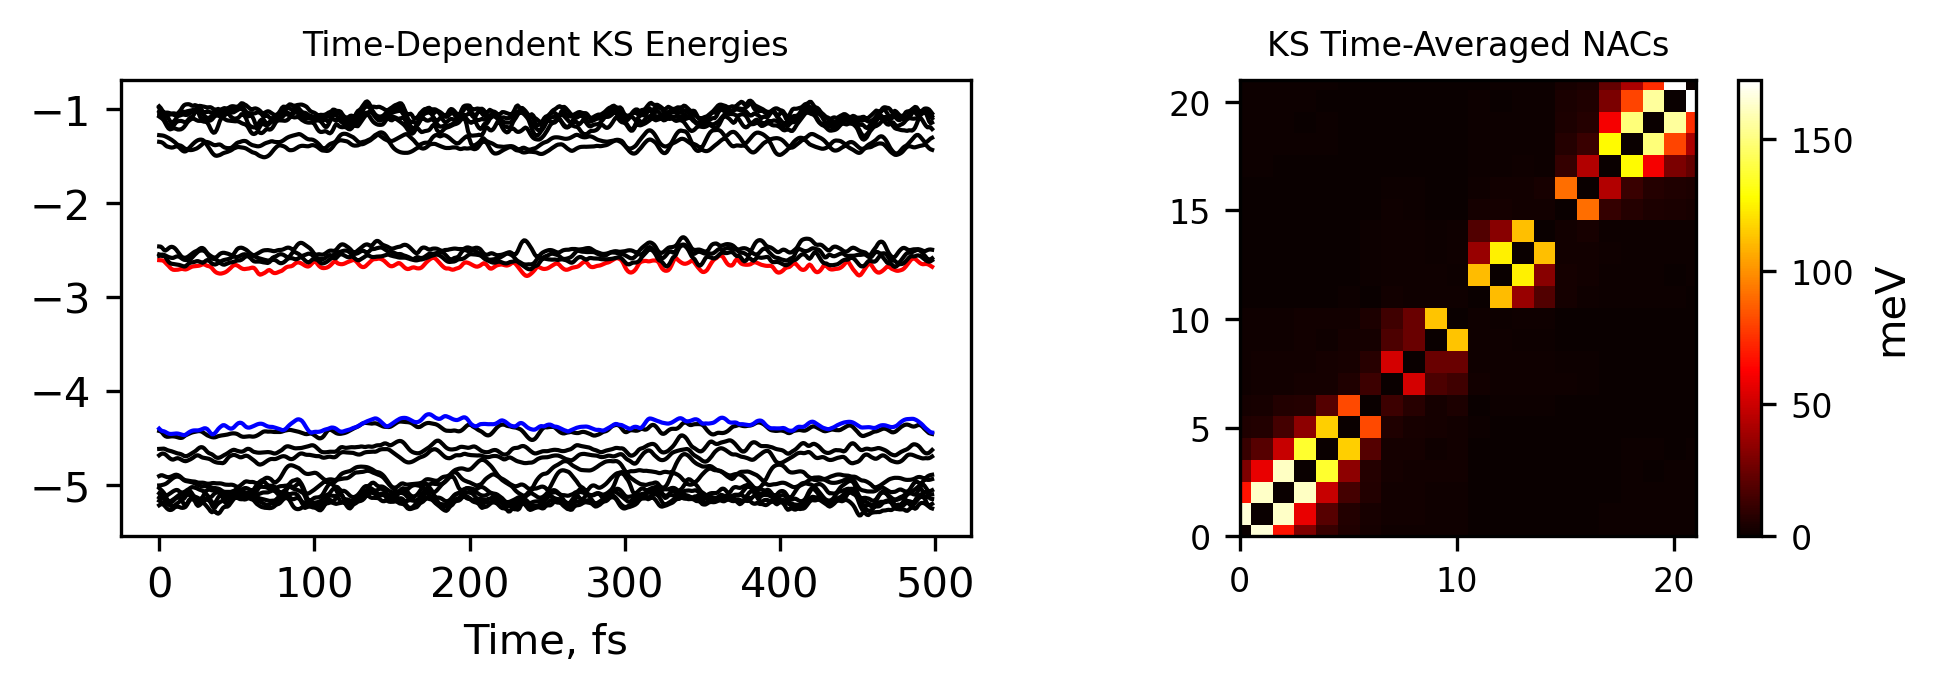

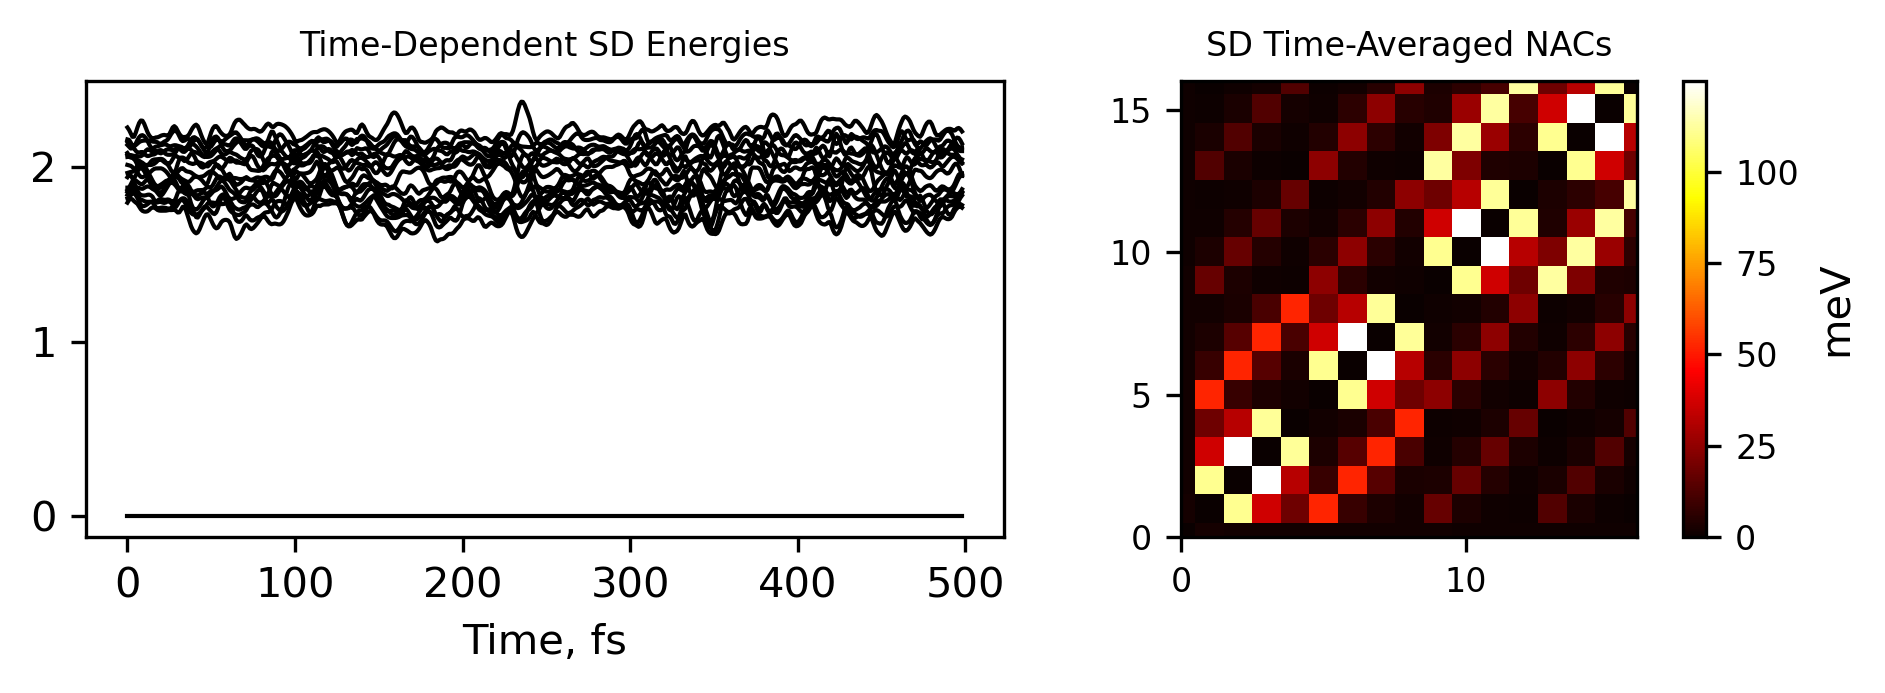

In [16]:
# Figures - Time-Dependent Data
plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
plt.subplot(1,2,1)
plt.title('Time-Dependent KS Energies', fontsize=8)
plt.xlabel('Time, fs')
for ks_index in range( num_alpha_ks_orbs ):
    if ks_index == 10:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="CBM", linewidth=1, color = "blue")
    elif ks_index == 11:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="VBM", linewidth=1, color = "red")
    else:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="", linewidth=1, color = "black")
plt.tight_layout()

plt.subplot(1,2,2)
plt.title('KS Time-Averaged NACs', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0,num_alpha_ks_orbs-1)
plt.ylim(0,num_alpha_ks_orbs-1)
#plt.xticks([0,1,2,3,4,5,6,7,8,9])
#plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.imshow(ks_tNACs, cmap='hot', interpolation='nearest')
cb = plt.colorbar(label="meV")
cb.ax.tick_params(labelsize=8)


plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
plt.subplot(1,2,1)
plt.title('Time-Dependent SD Energies', fontsize=8)
plt.xlabel('Time, fs')
for sd_index in range( nSDs ):
    plt.plot(md_time, (SD_energy[sd_index]-SD_energy[0])/units.ev2Ha, label="", linewidth=1, color = "black")
plt.tight_layout()

plt.subplot(1,2,2)
plt.title('SD Time-Averaged NACs', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0,nSDs-1)
plt.ylim(0,nSDs-1)
#plt.xticks([0,1,2,3,4,5,6,7,8,9])
#plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.imshow(sd_tNACs, cmap='hot', interpolation='nearest')
cb = plt.colorbar(label="meV")
cb.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()